In [1]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import random
from collections import OrderedDict, defaultdict
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Normalize, Resize
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from oxford_flowers import  Oxford102FlowersTrain, Oxford102FlowersTest, normalize_mean, normalize_std
from mnist import  MNISTTrain, MNISTTest
os.environ["CUDA_LAUNCH_BLOCKING"]= "1"
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
plt.style.use("seaborn-v0_8")

In [2]:
# batch_size = 16
# train_loader = DataLoader(dataset=Oxford102FlowersTrain(transform=Compose([ToTensor(),])),
# train_loader = DataLoader(dataset=Oxford102FlowersTrain(which=["train"], transform=Compose([ToTensor(), 
#                                                                                             Resize((256, 256)),  
#                                                                                             ])),
#                           batch_size=batch_size,) 
                        #   shuffle=False,  num_workers=2)
# test_loader = DataLoader(dataset=MNISTTest(transform=Compose([ToTensor(),])),
#                           batch_size=batch_size, shuffle=False)


In [3]:

# for x, x_target, label in train_loader:
#    break

In [4]:
# x.size(), x_target.size()

In [5]:
# x_target[0]

In [6]:
batch_size = 128 * 5
train_loader = DataLoader(dataset=MNISTTrain(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=MNISTTest(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=False)

In [7]:
def get_activation(act_name):
    return {"relu": nn.ReLU(), "elu": nn.ELU(), "gelu": nn.GELU(), "tanh": nn.Tanh()}[act_name]


class Masked2dConvolution(nn.Conv2d):
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride=1, padding="same"):
        self.mask_type = mask_type
        self.mask = self.get_mask(mask_type, mask_size=kernel_size)

        super().__init__(in_channels, out_channels, kernel_size, stride, padding, groups=1, bias=True,)
    
    def get_mask(self, mask_type, mask_size):
        mask = torch.zeros(mask_size[0] * mask_size[1]).float()
        middle = mask.size(0) // 2 
        if mask_type == "B":
            middle = middle + 1
        mask[:middle] = 1.
        return mask.unsqueeze(0).unsqueeze(0).view(1, 1, mask_size[0], mask_size[1]).contiguous()
    
    def forward(self, x):
        weight = self.weight * self.mask.to(self.weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)  

class ResidualBlock(nn.Module):
    
    def __init__(self, filter_size, activation="relu") -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(filter_size, filter_size // 2, (1, 1), padding="same")
        self.activation1 = get_activation(activation)
        self.masked_conv = Masked2dConvolution("B", filter_size // 2, filter_size // 2, (3, 3), padding="same")
        self.activation2 = get_activation(activation)
        self.conv2 = nn.Conv2d(filter_size // 2, filter_size, (1, 1),  padding="same")
        self.activation3 = get_activation(activation)
        
    
    def forward(self, x):
        x_ = self.conv1(x)
        x_ = self.activation1(x_)
        x_ = self.masked_conv(x_)
        x_ = self.activation2(x_)
        x_ = self.conv2(x_)
        x_ = self.activation3(x_)
        return x + x_
        
    
Masked2dConvolution("B", 3, 32, (1, 1))(torch.randn(2,3, 16, 16)).size()

torch.Size([2, 32, 16, 16])

In [8]:
class PixelCNN(nn.Module):
    def __init__(self, filter_size=128, nlayers=5):
        super().__init__()
        self.masked_conv = Masked2dConvolution("A", 1, filter_size, (7, 7))
        self.residual_blocks = nn.ModuleList([ResidualBlock(filter_size) for _ in range(nlayers)])
        self.after_residual = nn.ModuleList([Masked2dConvolution("B", filter_size, filter_size, (1, 1)), nn.ReLU()] + \
             [Masked2dConvolution("B", filter_size, filter_size, (1, 1)), nn.ReLU()])
        self.out = nn.Conv2d(filter_size, 256, (1, 1), padding="same")
    
    def forward(self, x):
        
        x = self.masked_conv(x)
        for block in self.residual_blocks:
            x = block(x)
        for residual in self.after_residual:
            x = residual(x)
        x = self.out(x)
        
        return x.unsqueeze(2)
        

In [9]:
def sample_dist(probs, temperature):
    probs = probs ** (1 / temperature)
    probs = probs / probs.sum(axis=1).unsqueeze(1)
    return torch.multinomial(probs, 1)

def generate(model, nsamples = 2, temperature=1.0):
    model.eval()
    
    with torch.no_grad():
        height, width, channels = 28, 28, 1
        imgs = torch.zeros((nsamples, channels, height, width)).cuda()
        
        for i in range(height):
            for j in range(width):
                for k in range(channels):
                    logits = model(imgs)
                    probs = torch.softmax(logits[:, :, k, i, j], dim=-1)
                    pixel = sample_dist(probs, temperature)
                    imgs[:, k, i, j] = pixel.flatten() / 255.0
        return (imgs.clone().detach().cpu().permute(0, 2, 3, 1).contiguous().numpy() * 255.0).astype(np.uint8)

def save_samples(samples, savepath):
    for i in range(samples.shape[0]):
        Image.fromarray(samples[i].reshape(28, 28).astype(np.uint8)).save(os.path.join(savepath, f"{i:03d}.png"))

class Criterion(nn.Module):
    
    def forward(self, input, target):
        b, f, c, h, w = input.size()
        x = input.permute(0, 3, 4, 2, 1).contiguous().view(-1, f)
        x_hat = target.permute(0, 2, 3, 1).view(-1, )
        
        return F.cross_entropy(x, x_hat, reduction="mean")
                

In [10]:

def train(model_name):
    savepath = os.path.join(f"/mnt/dl/models/{model_name}")
    model_savepath = os.path.join(savepath, "models")
    eval_savepath = os.path.join(savepath, "eval")
    
    os.makedirs(model_savepath, exist_ok=True)
    os.makedirs(eval_savepath, exist_ok=True)
    
    model = PixelCNN().cuda()
    criterion = Criterion()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9998) 
    epochs = 500
    
    losses = []
    it = 0
    for i in range(epochs):
        model.train()
        print("Starting Epoch ", i, "...")
        for j, (img, label) in enumerate(train_loader):
            img = img.cuda()
            target = img.clone().long()
            img /= 255.0
            out = model(img)
            loss = criterion(out, target)
            optimizer.zero_grad()
            loss.backward()
            it += 1
            nn.utils.clip_grad_norm_(model.parameters(), 10.)
            optimizer.step()
            losses.append(loss.item())
            if it % 50 == 0:
                print(f"Epoch: {i}, batch: {j}, loss: {np.mean(losses[-100:])}")
        if i % 2 == 0:
            scheduler.step()
        
        if i % 50 == 0:
            samples = generate(model, 50, temperature=1)
            samples_savepath = os.path.join(eval_savepath, f"{i}")
            os.makedirs(samples_savepath, exist_ok=True)
            save_samples(samples, samples_savepath)
            model.train()
        
        if i % 100 == 0:
            torch.save({"model": model.state_dict(), "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict()},
                       os.path.join(model_savepath, f"checkpoint{i:04d}.pt"))
            
               
            

    return model, losses

In [12]:
model, losses = train("pixel_cnn")

Starting Epoch  0 ...
Epoch: 0, batch: 49, loss: 3.330314028263092
Epoch: 0, batch: 99, loss: 2.539150809049606
Epoch: 0, batch: 149, loss: 1.614557752609253
Epoch: 0, batch: 199, loss: 1.417636708021164
Epoch: 0, batch: 249, loss: 1.319697256088257
Epoch: 0, batch: 299, loss: 1.2628645968437195
Epoch: 0, batch: 349, loss: 1.2357085621356965
Starting Epoch  1 ...
Epoch: 1, batch: 24, loss: 1.211790043115616
Epoch: 1, batch: 74, loss: 1.1934005188941956
Epoch: 1, batch: 124, loss: 1.1820778703689576
Epoch: 1, batch: 174, loss: 1.1674720895290376
Epoch: 1, batch: 224, loss: 1.1577508985996245
Epoch: 1, batch: 274, loss: 1.151179577112198
Epoch: 1, batch: 324, loss: 1.1398503494262695
Epoch: 1, batch: 374, loss: 1.1239033818244935
Starting Epoch  2 ...
Epoch: 2, batch: 49, loss: 1.1189468121528625
Epoch: 2, batch: 99, loss: 1.1100415694713592
Epoch: 2, batch: 149, loss: 1.0982978177070617
Epoch: 2, batch: 199, loss: 1.0931641674041748
Epoch: 2, batch: 249, loss: 1.0898297929763794
Epoch: 

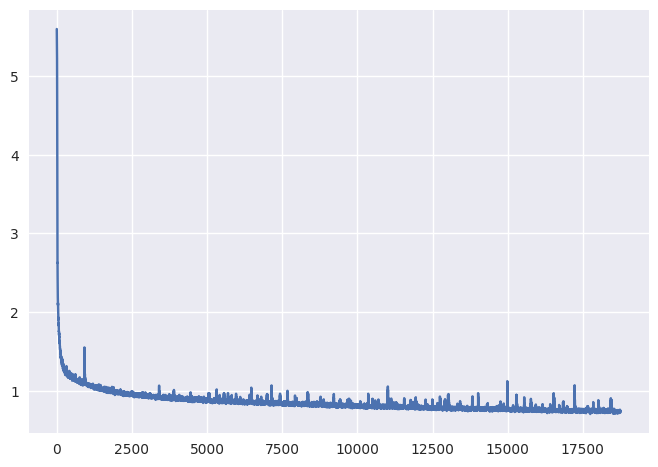

In [ ]:
plt.plot(losses)